# Bayesian Persuasion

**Inspired by:** Kamenica, E., & Gentzkow, M. (2011). _Bayesian persuasion._ American Economic Review, 101(6), 2590-2615.

Suppose a defendant is 30% likely to be guilty. Without any further evidence, a judge would always acquit such a defendant. The prosecutor is thus motivated to gather evidence by ordering tests (e.g. lie detectors). Suppose the prosecutor gets to choose a test, among a menu of options with different precisions and recalls. Of course, once a test is ordered, the test's results _must_ be reported to the judge. Note that the judge will know the test's parameters, and furthermore will also know that the prosecutor strategically chose the test's parameters.

The prosecutor could order a test with perfect precision/recall, in which case the judge would have perfect information about the defendant's guilt and thus convict 30% of the time. The question is: _can the prosecutor somehow do better than 30%?_

Kamenica and Gentzkow offered a test that (shockingly) raises the conviction rate to 60%. We show how to automatically design such a test, by searching over 10,000 options.

In [1]:
from memo import memo, domain
import jax.numpy as np
import jax
from enum import IntEnum
from matplotlib import pyplot as plt

In [2]:
class State(IntEnum):
    Innocent = 0
    Guilty = 1

class Result(IntEnum):
    Exonerating = 0
    Incriminating = 1

class Verdict(IntEnum):
    Acquit = 0
    Convict = 1

Probability = np.linspace(0.5, 1, 100 + 1)
Test = domain(pi_i=len(Probability), pi_g=len(Probability))

@jax.jit
def run_test(r, s, t):
    p_i, p_g = Test._tuple(t)
    p_i = Probability[p_i]
    p_g = Probability[p_g]
    return np.array([
        [p_i, 1 - p_i],
        [1 - p_g, p_g]
    ])[s, r]

The prosecutor and judge are a pair of mutually recursive models. The prosecutor chooses a test, and the judge observes the test's outcome for a randomly-chosen defendant.

In [3]:
@memo
def prosecutor[t: Test](level):
    # prosecutor maximizes p(judge convicts)
    pros: chooses(t in Test, wpp=exp(20 * judge[t](level)))
    return Pr[pros.t == t]

@memo
def judge[t: Test](level):
    judge: thinks[
        defendant: chooses(s in State, wpp=0.7 if s == 0 else 0.3),
        prosecutor: chooses(t in Test, wpp=prosecutor[t](level - 1) if level > 0 else 1),
        defendant: knows(prosecutor.t),
        defendant: chooses(r in Result, wpp=run_test(r, s, prosecutor.t))
    ]

    defendant: chooses(s in State, wpp=0.7 if s == 0 else 0.3)
    defendant: knows(t)
    defendant: chooses(r in Result, wpp=run_test(r, s, t))

    judge: observes [prosecutor.t] is t
    judge: observes [defendant.r] is defendant.r
    judge: chooses(v in Verdict, to_maximize=Pr[v == defendant.s])
    return Pr[judge.v == 1]

In [4]:
p = prosecutor(2)
j = judge(2)

%timeit -r 1 -n 10 prosecutor(2).block_until_ready()
%timeit -r 1 -n 10 judge(2).block_until_ready()

143 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
82.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


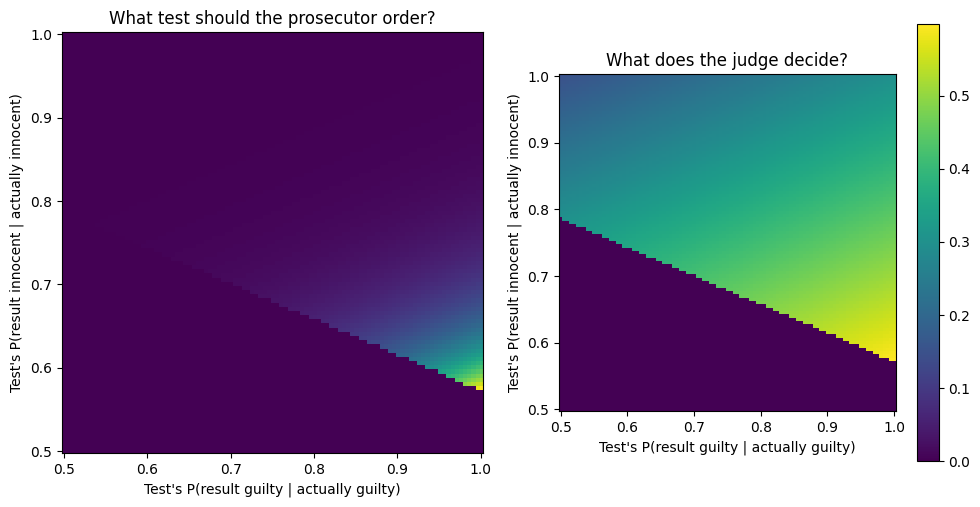

In [5]:
def showd(z, cb=False):
    z = z.reshape(len(Probability), len(Probability))
    img = plt.imshow(z, origin='lower')
    if cb: plt.colorbar(img)
    plt.xlabel("Test's P(result guilty | actually guilty)")
    plt.ylabel("Test's P(result innocent | actually innocent)")
    xt = np.linspace(0, 100, 6)
    xl = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    plt.xticks(xt, xl)
    plt.yticks(xt, xl)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
showd(p)
plt.title("What test should the prosecutor order?")
plt.subplot(1, 2, 2)
showd(j, cb=True)
plt.title("What does the judge decide?")
plt.tight_layout()

Interpreting the left chart: the prosecutor should pick a test that is perfectly accurate if the defendant is guilty, but only slightly better than chance if the defendant is innocent.

Interpreting the right chart: For uninformative tests (middle section) the judge never convicts, and for fully informative tests (top-right corner) the judge convicts 30% of the time. But, if faced with the prosecutor's optimal test, the judge convicts 60% of the time!

How does this compare to Kamenica & Gentzkow's solution?

In [6]:
pi_i, pi_g = Test._tuple(p.argmax().item())
print(f"K & G chose P(innocent|innocent) = {4/7:.3f}; we found {Probability[pi_i]:.3f}")
print(f"K & G chose P(guilty  |guilty  ) = {1:.3f}; we found {Probability[pi_g]:.3f}")

K & G chose P(innocent|innocent) = 0.571; we found 0.575
K & G chose P(guilty  |guilty  ) = 1.000; we found 1.000


Not bad!